In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
%matplotlib inline

# Data Visulization

In [2]:
def create_dataframe(path):
    feature_names = []
    for unit_label in ["T", "RA", "LA", "RL", "LL"]:
        for sensor  in ["acc","gyro","mag"]:
            for position in ['X','Y','Z']:
                feature_names.append(unit_label + "_" + position + sensor)

    return pd.read_csv(path, names = feature_names)

In [3]:
sit_df = create_dataframe('../data/a01/p1/s01.txt')
walk_df = create_dataframe('../data/a09/p1/s01.txt')
jump_df = create_dataframe('../data/a18/p1/s01.txt')

In [4]:
sit_df.head()

,T_Xacc,T_Yacc,T_Zacc,T_Xgyro,T_Ygyro,T_Zgyro,T_Xmag,T_Ymag,T_Zmag,RA_Xacc,...,RL_Zmag,LL_Xacc,LL_Yacc,LL_Zacc,LL_Xgyro,LL_Ygyro,LL_Zgyro,LL_Xmag,LL_Ymag,LL_Zmag
0,8.1305,1.0349,5.4217,-0.009461,0.001915,-0.003424,-0.78712,-0.069654,0.15730,0.70097,...,-0.036453,-2.8071,-9.0812,2.6220,-0.000232,-0.012092,-0.004457,0.74017,0.30053,-0.057730
1,8.1305,1.0202,5.3843,-0.009368,0.023485,0.001953,-0.78717,-0.068275,0.15890,0.71829,...,-0.034005,-2.8146,-9.0737,2.6218,-0.014784,-0.016477,0.002789,0.73937,0.30183,-0.057514
2,8.1604,1.0201,5.3622,0.015046,0.014330,0.000204,-0.78664,-0.068277,0.15879,0.69849,...,-0.036489,-2.8221,-9.0886,2.6366,-0.012770,0.005717,-0.007918,0.73955,0.30052,-0.057219
3,8.1603,1.0052,5.3770,0.006892,0.018045,0.005649,-0.78529,-0.069849,0.15912,0.72799,...,-0.036151,-2.8071,-9.0811,2.6070,-0.005725,0.009620,0.006555,0.74029,0.30184,-0.057750
4,8.1605,1.0275,5.3473,0.008811,0.030433,-0.005346,-0.78742,-0.068796,0.15916,0.71572,...,-0.033807,-2.8146,-9.0737,2.6218,-0.003929,-0.008371,0.002816,0.73845,0.30090,-0.057527


### Visualize accelerometer readings for sitting

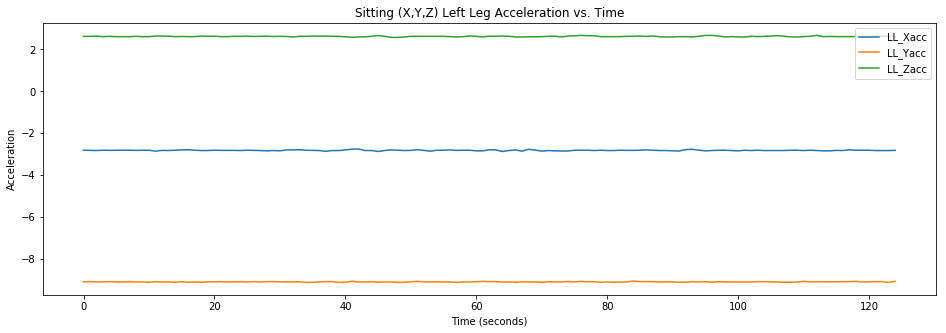

In [5]:
ax = sit_df[["LL_Xacc", "LL_Yacc", "LL_Zacc"]].plot(title = "Sitting (X,Y,Z) Left Leg Acceleration vs. Time", figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.show()

### Visualize accelerometer readings for jumping

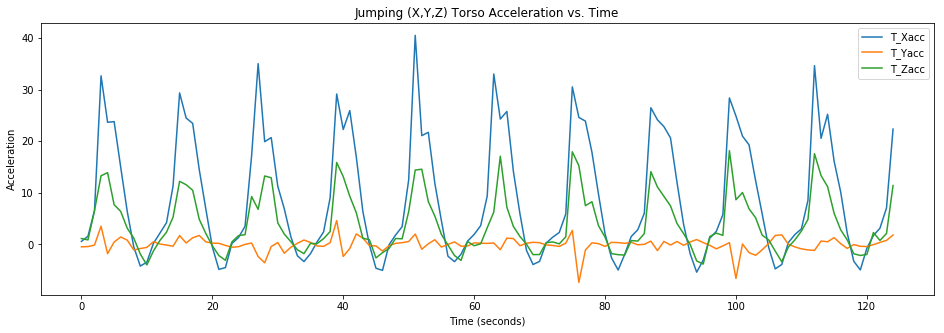

In [6]:
ax = jump_df[["T_Xacc", "T_Yacc", "T_Zacc"]].plot(title = "Jumping (X,Y,Z) Torso Acceleration vs. Time", figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.show()

### Visualize accelerometer readings for walking

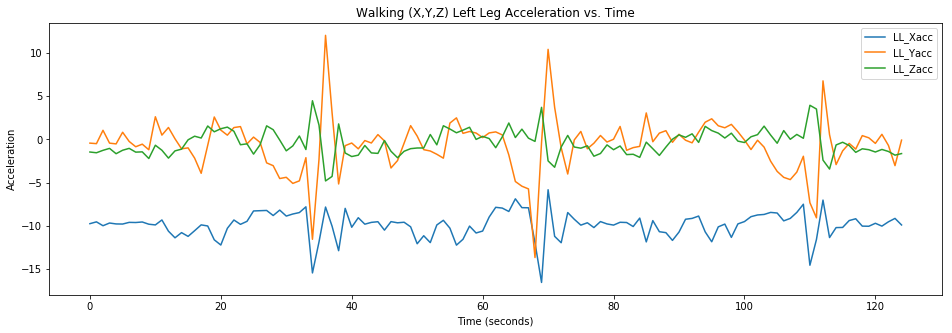

In [7]:
ax = walk_df[["LL_Xacc", "LL_Yacc", "LL_Zacc"]].plot(title = "Walking (X,Y,Z) Left Leg Acceleration vs. Time", figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.show()

# Feature Extraction

In [8]:
def generate_file_names():
    file_list = []
    for activities in range(19):
        for person in range(8):
            for segments in range(60):
                file_list.append('../data/' +
                                 'a' + str(activities + 1).zfill(2) + '/'
                                 'p' + str(person + 1) + '/'
                                 's' + str(segments + 1).zfill(2) + '.txt'
                                )

    return file_list

In [9]:
def extract_features(x):
    numrows = len(x)
    mean = np.mean(x, axis = 0)
    std = np.std(x, axis = 0)
    var = np.var(x, axis = 0)
    median = np.median(x, axis = 0)
    xmax = np.amax(x, axis = 0)
    xmin = np.amin(x, axis = 0)
    p2p = xmax - xmin
    amp = xmax - mean
    s2e = x[numrows-1,:] - x[0,:]
    features = np.concatenate([mean, std, var, median, xmax, xmin, p2p, amp, s2e])
    return features

In [10]:
def data_generate():
    filenames = generate_file_names()
    feature_cols = []
    for unit_label in ['T', 'RA', 'LA', 'RL', 'LL']:
        for feature in ['mean', 'std', 'var', 'median', 'xmax', 'xmin', 'p2p', 'amp', 's2e']:
            for sensor  in ['acc', 'gyro', 'mag']:
                for position in ['X', 'Y', 'Z']:
                    feature_cols.append(feature + '_' + unit_label + '_' + position + sensor)
    activity_data = pd.DataFrame(columns=feature_cols)
    data = []
    activity = []
    person = []
    for i in range(len(filenames)):
        activity.append('a' + str(i // 480 + 1).zfill(2))
        person.append('p' + str((i // 60) % 8 + 1))
        raw_data = np.genfromtxt(filenames[i], delimiter = ',', skip_header = 0)
        row = extract_features(raw_data)
        data.append(row)
    #data = scale(data, axis = 0)
    activity_data = pd.DataFrame(data, columns = feature_cols)
    activity_data['person'] = person
    activity_data['activity'] = activity
    return activity_data

# Preprocess Data

In [11]:
def preprocess_approach_one():
    df = pd.read_csv('data/data.csv')
    train_df = df.loc[df['person'] != 'p8']
    test_df = df.loc[df['person'] == 'p8']

    train_x = np.vstack((train_df.iloc[:, 0:81].values, 
                         train_df.iloc[:, 81:162].values, 
                         train_df.iloc[:, 162:243].values, 
                         train_df.iloc[:, 243:324].values, 
                         train_df.iloc[:, 324:405].values))
    
    train_y = np.vstack((train_df['activity'].str.get_dummies().values,
                         train_df['activity'].str.get_dummies().values,
                         train_df['activity'].str.get_dummies().values,
                         train_df['activity'].str.get_dummies().values,
                         train_df['activity'].str.get_dummies().values))
    
    test_t_x = test_df.iloc[:, 0:81].values
    test_ra_x = test_df.iloc[:, 81:162].values
    test_la_x = test_df.iloc[:, 162:243].values
    test_rl_x = test_df.iloc[:, 243:324].values
    test_ll_x = test_df.iloc[:, 324:405].values
    
    test_y = test_df['activity'].str.get_dummies().values
    
    # Normalize
    train_x = normalize(train_x, norm='l2')
    
    test_t_x = normalize(test_t_x, norm='l2')
    test_ra_x = normalize(test_ra_x, norm='l2')
    test_la_x = normalize(test_la_x, norm='l2')
    test_rl_x = normalize(test_rl_x, norm='l2')
    test_ll_x = normalize(test_ll_x, norm='l2')
    
    # Expand dimensions
    train_x = np.expand_dims(train_x, axis = 1)
    
    test_t_x = np.expand_dims(test_t_x, axis = 1)
    test_ra_x = np.expand_dims(test_ra_x, axis = 1)
    test_la_x = np.expand_dims(test_la_x, axis = 1)
    test_rl_x = np.expand_dims(test_rl_x, axis = 1)
    test_ll_x = np.expand_dims(test_ll_x, axis = 1)
    
    return (train_x, test_t_x, test_ra_x, test_la_x, test_rl_x, test_ll_x, train_y, test_y)

In [12]:
(train_x_one, test_t_x_one, test_ra_x_one, test_la_x_one, test_rl_x_one, test_ll_x_one, train_y_one, test_y_one) = preprocess_approach_one()

In [13]:
def preprocess_approach_two():
    df = pd.read_csv('data/data.csv')
    train_df = df.loc[df['person'] != 'p8']
    test_df = df.loc[df['person'] == 'p8']
    
    # Train x values
    train_t_x = train_df.iloc[:, 0:81].values
    train_ra_x = train_df.iloc[:, 81:162].values
    train_la_x = train_df.iloc[:, 162:243].values
    train_rl_x = train_df.iloc[:, 243:324].values
    train_ll_x = train_df.iloc[:, 324:405].values
    
    # Test x values
    test_t_x = test_df.iloc[:, 0:81].values
    test_ra_x = test_df.iloc[:, 81:162].values
    test_la_x = test_df.iloc[:, 162:243].values
    test_rl_x = test_df.iloc[:, 243:324].values
    test_ll_x = test_df.iloc[:, 324:405].values
    
     # Normalize
    train_t_x = normalize(train_t_x, norm='l2')
    train_ra_x = normalize(train_ra_x, norm='l2')
    train_la_x = normalize(train_la_x, norm='l2')
    train_rl_x = normalize(train_rl_x, norm='l2')
    train_ll_x = normalize(train_ll_x, norm='l2')
    
    test_t_x = normalize(test_t_x, norm='l2')
    test_ra_x = normalize(test_ra_x, norm='l2')
    test_la_x = normalize(test_la_x, norm='l2')
    test_rl_x = normalize(test_rl_x, norm='l2')
    test_ll_x = normalize(test_ll_x, norm='l2')
    
    # Expand dimensions
    train_t_x = np.expand_dims(train_t_x, axis = 1)
    train_ra_x = np.expand_dims(train_ra_x, axis = 1)
    train_la_x = np.expand_dims(train_la_x, axis = 1)
    train_rl_x = np.expand_dims(train_rl_x, axis = 1)
    train_ll_x = np.expand_dims(train_ll_x, axis = 1)
    
    test_t_x = np.expand_dims(test_t_x, axis = 1)
    test_ra_x = np.expand_dims(test_ra_x, axis = 1)
    test_la_x = np.expand_dims(test_la_x, axis = 1)
    test_rl_x = np.expand_dims(test_rl_x, axis = 1)
    test_ll_x = np.expand_dims(test_ll_x, axis = 1)
    
    # Y labels for train
    train_y = train_df['activity'].str.get_dummies().values
    
    # Y labels for test
    test_y = test_df['activity'].str.get_dummies().values
    
    return (train_t_x, train_ra_x, train_la_x, train_rl_x, train_ll_x, test_t_x, test_ra_x, test_la_x, test_rl_x, test_ll_x, train_y, test_y)
    

In [14]:
(train_t_x, train_ra_x, train_la_x, train_rl_x, train_ll_x, test_t_x, test_ra_x, test_la_x, test_rl_x, test_ll_x, train_y, test_y) = preprocess_approach_two()

In [15]:
def preprocess_regular():
    data = pd.read_csv('data/data.csv')
    
    train = data.loc[data['person'] != 'p8']
    test = data.loc[data['person'] == 'p8']
    train = train.drop(['person'], axis = 1)
    test = test.drop(['person'], axis = 1)
    train_x = train.iloc[:, :-1].values
    train_y = train.iloc[:, -1].values
    test_x = test.iloc[:, :-1].values
    test_y = test.iloc[:, -1].values
    
    train_y = train['activity'].str.get_dummies().values
    test_y = test['activity'].str.get_dummies().values
    
    train_x = np.expand_dims(train_x, axis = 1)
    test_x = np.expand_dims(test_x, axis = 1)
    
    return(train_x, train_y, test_x, test_y)

In [16]:
(train_x_n, train_y_n, test_x_n, test_y_n) = preprocess_regular()

# CNN Model

In [17]:
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [18]:
def schedule_rate(epoch):
    if epoch > 75:
        return 0.0005
    elif epoch > 100:
        return 0.0003       
    return 0.001

In [19]:
def deep_network(input_shape, output_shape):
    model = Sequential()
    
    model.add(Conv1D(filters = 32, kernel_size = 3, input_shape = input_shape, data_format='channels_first'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size = 2))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters = 64, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size = 2))
    model.add(Dropout(0.3))
    
    model.add(LSTM(128, return_sequences=True, input_shape = input_shape))
    model.add(LSTM(128))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(output_shape, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
              
    return model

### Approach 1

In [20]:
model_one = deep_network((1, 81), 19)

In [21]:
history_app_one = model_one.fit(x = train_x_one, y = train_y_one, epochs = 10)

Epoch 1/10
39900/39900 [==============================] - 62s 2ms/step - loss: 1.2319 - acc: 0.5518
Epoch 2/10
39900/39900 [==============================] - 53s 1ms/step - loss: 0.6564 - acc: 0.7633
Epoch 3/10
39900/39900 [==============================] - 53s 1ms/step - loss: 0.5197 - acc: 0.8229
Epoch 4/10
39900/39900 [==============================] - 53s 1ms/step - loss: 0.4342 - acc: 0.8574
Epoch 5/10
39900/39900 [==============================] - 54s 1ms/step - loss: 0.3871 - acc: 0.8787
Epoch 6/10
39900/39900 [==============================] - 57s 1ms/step - loss: 0.3578 - acc: 0.8871
Epoch 7/10
39900/39900 [==============================] - 53s 1ms/step - loss: 0.3224 - acc: 0.8999
Epoch 8/10
39900/39900 [==============================] - 54s 1ms/step - loss: 0.3079 - acc: 0.9055
Epoch 9/10
39900/39900 [==============================] - 52s 1ms/step - loss: 0.2825 - acc: 0.9149
Epoch 10/10
39900/39900 [==============================] - 54s 1ms/step - loss: 0.2696 - acc: 0.9186

In [30]:
t_score_one = model_one.evaluate(test_t_x_one, test_y_one)
ra_score_one = model_one.evaluate(test_ra_x_one, test_y_one)
la_score_one = model_one.evaluate(test_la_x_one, test_y_one)
rl_score_one = model_one.evaluate(test_rl_x_one, test_y_one)
ll_score_one = model_one.evaluate(test_ll_x_one, test_y_one)

app_one_scores = dict(zip(('Torso', 'Right arm', 'Left arm', 'Right leg', 'Left leg'), 
                     (t_score_one, ra_score_one, la_score_one, rl_score_one, ll_score_one)))

for position, scores in app_one_scores.items():
    print("For ", position, " accuracy is ", scores[1])

1140/1140 [==============================] - 1s 559us/step
For  Torso  accuracy is  0.8315789473684211
For  Right arm  accuracy is  0.6912280701754386
For  Left arm  accuracy is  0.8052631578947368
For  Right leg  accuracy is  0.76403508730102
For  Left leg  accuracy is  0.630701754595104


### Approach 2

In [31]:
model_t_two = deep_network((1, 81), 19)
model_ra_two = deep_network((1, 81), 19)
model_la_two = deep_network((1, 81), 19)
model_rl_two = deep_network((1, 81), 19)
model_ll_two = deep_network((1, 81), 19)

In [ ]:
model_t_two.fit(x = train_t_x, y = train_y, epochs = 100)
model_ra_two.fit(x = train_ra_x, y = train_y, epochs = 100)
model_la_two.fit(x = train_la_x, y = train_y, epochs = 100)
model_rl_two.fit(x = train_rl_x, y = train_y, epochs = 100)
model_ll_two.fit(x = train_ll_x, y = train_y, epochs = 100)

### Max Probability Approach

In [26]:
def get_score(model_t, model_ra, model_la, model_rl, model_ll, test_x, test_y):
    predictions_t = model_t.predict(test_x)
    predictions_ra = model_ra.predict(test_x)
    predictions_la = model_la.predict(test_x)
    predictions_rl = model_rl.predict(test_x)
    predictions_ll = model_ll.predict(test_x)
    
    predictions = []
    true = []
    
    for i in range(len(test_y)):
        p1 = np.max(predictions_t[i])
        p2 = np.max(predictions_ra[i])
        p3 = np.max(predictions_la[i])
        p4 = np.max(predictions_rl[i])
        p5 = np.max(predictions_ll[i])
        
        preds = np.array((p1, p2, p3, p4, p5))
        
        if(np.argmax(preds) == 0):
            predictions.append(np.argmax(predictions_t[i]))
        elif(np.argmax(preds) == 1):
            predictions.append(np.argmax(predictions_ra[i]))
        elif(np.argmax(preds) == 2):
            predictions.append(np.argmax(predictions_la[i]))
        elif(np.argmax(preds) == 3):
            predictions.append(np.argmax(predictions_rl[i]))
        elif(np.argmax(preds) == 4):
            predictions.append(np.argmax(predictions_ll[i]))
            
        true.append(np.argmax((test_y[i])))
    
    predictions = np.asarray(predictions)
    true = np.asarray(true)
    
    correct = np.where((predictions == true))
    total_correct = len(correct[0])
    
    accuracy = total_correct / len(test_y)
    return accuracy

In [33]:
t_score_two_max = get_score(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_t_x, test_y)
ra_score_two_max = get_score(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_ra_x, test_y)
la_score_two_max = get_score(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_la_x, test_y)
rl_score_two_max = get_score(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_rl_x, test_y)
ll_score_two_max = get_score(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_ll_x, test_y)

app_two_max_scores = dict(zip(('Torso', 'Right arm', 'Left arm', 'Right leg', 'Left leg'), 
                     (t_score_two_max, ra_score_two_max, la_score_two_max, rl_score_two_max, ll_score_two_max)))

for position, scores in app_two_max_scores.items():
    print("For ", position, " accuracy is ", scores)

For  Torso  accuracy is  0.7640350877192983
For  Right arm  accuracy is  0.6
For  Left arm  accuracy is  0.5114035087719299
For  Right leg  accuracy is  0.4324561403508772
For  Left leg  accuracy is  0.20877192982456141


### Averaged Probability Approach

In [73]:
def get_score_weighted(model_t, model_ra, model_la, model_rl, model_ll, test_x, test_y):
    
    from collections import defaultdict
    import operator
    
    predictions_t = model_t.predict(test_x)
    predictions_ra = model_ra.predict(test_x)
    predictions_la = model_la.predict(test_x)
    predictions_rl = model_rl.predict(test_x)
    predictions_ll = model_ll.predict(test_x)
    
    predictions = []
    true = []
    
    for i in range(len(test_y)):
        
        temp = defaultdict(list)
        
        argm1 = np.argmax(predictions_t[i])
        argm2 = np.argmax(predictions_ra[i])
        argm3 = np.argmax(predictions_la[i])
        argm4 = np.argmax(predictions_rl[i])
        argm5 = np.argmax(predictions_ll[i])
        
        am1 = np.max(predictions_t[i])
        am2 = np.max(predictions_ra[i])
        am3 = np.max(predictions_la[i])
        am4 = np.max(predictions_rl[i])
        am5 = np.max(predictions_ll[i])
        
        key = [argm1, argm2, argm3, argm4, argm5]
        val = [am1, am2, am3, am4, am5]
        
        for a, b in zip(key, val):
            temp[a].append(b)
        
        temp = dict(temp)
        
        for activity, probs in temp.items():
            probability = np.mean(np.array(probs))
            temp[activity] = probability
    
        activity = max(temp.items(), key=operator.itemgetter(1))[0]
        predictions.append(activity)
        true.append(np.argmax((test_y[i])))
        
    predictions = np.asarray(predictions)
    true = np.asarray(true)
    
    correct = np.where((predictions == true))
    total_correct = len(correct[0])
    
    accuracy = total_correct / len(test_y)
    return accuracy

In [74]:
t_score_two_avg = get_score_weighted(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_t_x, test_y)
ra_score_two_avg = get_score_weighted(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_ra_x, test_y)
la_score_two_avg = get_score_weighted(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_la_x, test_y)
rl_score_two_avg = get_score_weighted(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_rl_x, test_y)
ll_score_two_avg = get_score_weighted(model_t_two, model_ra_two, model_la_two, model_rl_two, model_ll_two, test_ll_x, test_y)

app_two_max_scores = dict(zip(('Torso', 'Right arm', 'Left arm', 'Right leg', 'Left leg'), 
                     (t_score_two_avg, ra_score_two_avg, la_score_two_avg, rl_score_two_avg, ll_score_two_avg)))

for position, scores in app_two_max_scores.items():
    print("For ", position, " accuracy is ", scores)

For  Torso  accuracy is  0.624561403508772
For  Right arm  accuracy is  0.5201754385964912
For  Left arm  accuracy is  0.5157894736842106
For  Right leg  accuracy is  0.4052631578947368
For  Left leg  accuracy is  0.20087719298245615


# Approach 1 using other Supervised learning Algorithms

In [22]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import warnings
warnings.filterwarnings("ignore")

### Preprocess Data

In [23]:
def preprocess_approach_one_others():
    df = pd.read_csv('data/data.csv')
    train_df = df.loc[df['person'] != 'p8']
    test_df = df.loc[df['person'] == 'p8']

    train_x = np.vstack((train_df.iloc[:, 0:81].values, 
                         train_df.iloc[:, 81:162].values, 
                         train_df.iloc[:, 162:243].values, 
                         train_df.iloc[:, 243:324].values, 
                         train_df.iloc[:, 324:405].values))
    
    train_y = np.hstack((train_df['activity'].values,
                         train_df['activity'].values,
                         train_df['activity'].values,
                         train_df['activity'].values,
                         train_df['activity'].values))
    
    test_t_x = test_df.iloc[:, 0:81].values
    test_ra_x = test_df.iloc[:, 81:162].values
    test_la_x = test_df.iloc[:, 162:243].values
    test_rl_x = test_df.iloc[:, 243:324].values
    test_ll_x = test_df.iloc[:, 324:405].values
    
    test_y = test_df['activity'].values
    
    # Normalize
    train_x = normalize(train_x, norm='l2')
    
    test_t_x = normalize(test_t_x, norm='l2')
    test_ra_x = normalize(test_ra_x, norm='l2')
    test_la_x = normalize(test_la_x, norm='l2')
    test_rl_x = normalize(test_rl_x, norm='l2')
    test_ll_x = normalize(test_ll_x, norm='l2')
    
    return (train_x, test_t_x, test_ra_x, test_la_x, test_rl_x, test_ll_x, train_y, test_y)

In [24]:
(train_x_o, test_t_x_o, test_ra_x_o, test_la_x_o, test_rl_x_o, test_ll_x_o, train_y_o, test_y_o) = preprocess_approach_one_others()

### Define all the classifiers

In [97]:
classifiers = {
    "LogisticRegression": LogisticRegression(solver='lbfgs', multi_class='multinomial'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Perceptron": Perceptron(),
    "NaiveBayes": GaussianNB()
}

fitted_models = {}

### Train and calculate accuracy

In [98]:
for key, classifier in classifiers.items():
    
    fitted_models[key] = classifier.fit(train_x_o, train_y_o)
    train_score = classifier.score(train_x_o, train_y_o)
    test_t_x_score = classifier.score(test_t_x_o, test_y_o)
    test_ra_x_score = classifier.score(test_ra_x_o, test_y_o)
    test_la_x_score = classifier.score(test_la_x_o, test_y_o)
    test_rl_x_score = classifier.score(test_rl_x_o, test_y_o)
    test_ll_x_score = classifier.score(test_ll_x_o, test_y_o)
    
    print("Performance for ", key, "\n", 
          "Train score = ", train_score, "\n",
          "Torso Test scores = ", test_t_x_score, "\n",
          "RA Test scores = ", test_ra_x_score, "\n",
          "RL Test scores = ", test_la_x_score, "\n",
          "LA Test scores = ", test_rl_x_score, "\n",
          "LL Test scores = ", test_ll_x_score, "\n",)
    
    print("\n")

Performance for  LogisticRegression 
 Train score =  0.6849874686716791 
 Torso Test scores =  0.7315789473684211 
 RA Test scores =  0.6403508771929824 
 RL Test scores =  0.7131578947368421 
 LA Test scores =  0.443859649122807 
 LL Test scores =  0.22456140350877193 



Performance for  KNearest 
 Train score =  0.9608771929824561 
 Torso Test scores =  0.8166666666666667 
 RA Test scores =  0.6921052631578948 
 RL Test scores =  0.7763157894736842 
 LA Test scores =  0.6789473684210526 
 LL Test scores =  0.5403508771929825 



Performance for  Support Vector Classifier 
 Train score =  0.4889724310776942 
 Torso Test scores =  0.42543859649122806 
 RA Test scores =  0.5236842105263158 
 RL Test scores =  0.7350877192982456 
 LA Test scores =  0.4964912280701754 
 LL Test scores =  0.10701754385964912 



Performance for  DecisionTreeClassifier 
 Train score =  1.0 
 Torso Test scores =  0.624561403508772 
 RA Test scores =  0.7 
 RL Test scores =  0.5412280701754386 
 LA Test scor

### Save all the models

In [93]:
def save_models():
    import joblib
    for key, classifier in fitted_models.items():
        filename = key + '.joblib'
        joblib.dump(classifier, filename)

### Retrieve Models

In [38]:
def load_models(directory):
    import joblib
    import glob
    loaded_models = {}
    path = directory + '*.joblib'
    files = glob.glob(path)
    for file in files:
        clf = joblib.load(file)
        key = file.split('/')[-1].split('.')[0]
        loaded_models[key] = clf 
    return loaded_models

In [43]:
loaded_models = load_models('models/')

In [44]:
loaded_models

{'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'KNearest': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
 'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False),
 'NaiveBayes': GaussianNB(priors=None),
 'Perceptron': Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
       max_i